## Prediction Scenario

Imagine we are looking at a new data point that represents a specific time period, category, data type, and location in the dataset. I used a real example row from the test set and asked the model to predict the value.

For that example, the model predicted a value of about 4,078. This number is the model’s best guess for `val` given the inputs. The prediction should not be treated as an exact forecast, but it shows how the model can take basic identifiers from the dataset and produce an estimated value.

In [27]:
# Create a realistic example scenario using recent values
example = X_test.iloc[0].to_frame().T

prediction = model.predict(example)[0]

prediction

np.float64(4078.2560587527387)

## Model Evaluation

The model achieved an R2 score of about 0.08, which means it explains a small portion of the variation in the data. This suggests that while the model captures some general patterns, many factors that influence business formation are not included in the dataset.

The Mean Squared Error is relatively large, which is expected given the wide range of values in the data. Overall, the model is better at identifying general trends than making precise predictions.

In [26]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("R2:", r2)
print("MSE:", mse)

R2: 0.07543632763497743
MSE: 198944267.8929486


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

X = model_df[["per_idx", "cat_idx", "dt_idx", "geo_idx", "is_adj"]]
y = model_df["val"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = LinearRegression()
model.fit(X_train, y_train)

"Model trained"

'Model trained'

In [24]:
# Keep only the columns we need
model_df = df[["per_idx", "cat_idx", "dt_idx", "geo_idx", "is_adj", "val"]].copy()

# Convert everything to numbers (turns weird text into NaN)
for col in model_df.columns:
    model_df[col] = pd.to_numeric(model_df[col], errors="coerce")

# Drop rows with missing values
model_df = model_df.dropna()

model_df.head(), model_df.shape

(   per_idx  cat_idx  dt_idx  geo_idx  is_adj       val
 0        7        1       1        1       0  166448.0
 1        8        1       1        1       0  171070.0
 2        9        1       1        1       0  162742.0
 3       10        1       1        1       0  207389.0
 4       11        1       1        1       0  176104.0,
 (401552, 6))

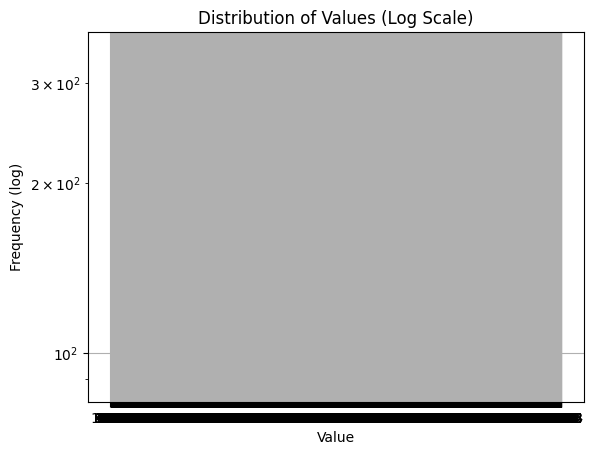

In [23]:
df["val"].sample(5000, random_state=42).hist(bins=30)
plt.yscale("log")
plt.title("Distribution of Values (Log Scale)")
plt.xlabel("Value")
plt.ylabel("Frequency (log)")
plt.show()

## Exploratory Data Analysis Summary

From the initial exploration, the `val` column shows a wide range of values, with many smaller values and some much larger ones. This suggests the data is skewed and may contain spikes. A histogram helps visualize how frequently different values occur and shows that extreme values are less common.

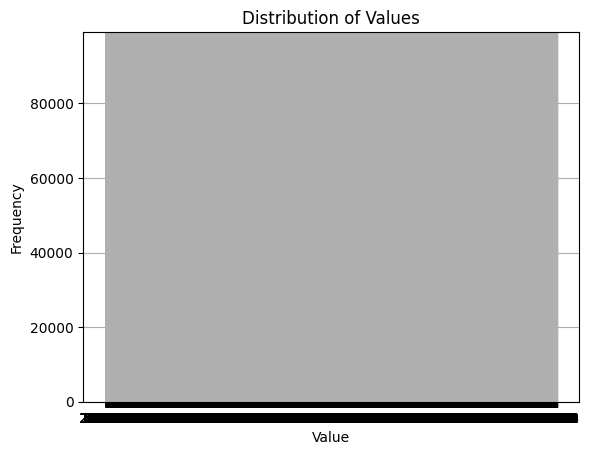

In [22]:
df["val"].hist(bins=30)
plt.title("Distribution of Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

In [21]:
import matplotlib.pyplot as plt

In [20]:
df["val"].hist(bins=30)
plt.title("Distribution of Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.show()

NameError: name 'plt' is not defined

Error in callback <function flush_figures at 0x7a0db1b04fe0> (for post_execute):


KeyboardInterrupt: 

In [19]:
df["val"].describe()

,val
count,407592
unique,27301
top,D
freq,5988


## Target Variable

The target variable for this project is `val`, which represents the numeric value being measured in the Business Formation Statistics dataset. The goal is to understand what influences this value and whether it can be predicted using a simple model.

In [18]:
df.columns

Index(['per_idx', 'cat_idx', 'dt_idx', 'geo_idx', 'is_adj', 'val'], dtype='object')

In [17]:
import pandas as pd
import csv

df = pd.read_csv(
    "BFS-mf.csv",
    skiprows=381,
    engine="python",
    sep=",",
    quoting=csv.QUOTE_NONE,
    on_bad_lines="skip"
)

df.head()


,per_idx,cat_idx,dt_idx,geo_idx,is_adj,val
0,7,1,1,1,0,166448
1,8,1,1,1,0,171070
2,9,1,1,1,0,162742
3,10,1,1,1,0,207389
4,11,1,1,1,0,176104


In [16]:
import pandas as pd

df = pd.read_csv(
    "BFS-mf.csv",
    skiprows=381,        # skip everything before the DATA section
    engine="python",
    on_bad_lines="skip"
)

df.head()


Error: ',' expected after '"'

In [15]:
# Find where "DATA" shows up in the file
data_lines = []

with open("BFS-mf.csv", "r", encoding="utf-8", errors="ignore") as f:
    for i, line in enumerate(f):
        if line.strip().upper() == "DATA":
            data_lines.append(i)

data_lines[:10], len(data_lines)


([380], 1)

In [14]:
import os
os.listdir()


['.config', '.ipynb_checkpoints', 'BFS-mf.csv', 'sample_data']

In [12]:
df.sample(5, random_state=42)


,cat_idx,cat_code,cat_desc,cat_indent
193,97,Jan-2012,None,None
33,10,BF_SBF8Q,Spliced Business Formations within Eight Quarters,UNITS
15,16,NAICS61,Educational Services,1
309,213,Sep-2021,None,None
57,20,IN,Indiana,None


In [11]:
df.shape


(365, 4)

In [10]:
df.columns


Index(['cat_idx', 'cat_code', 'cat_desc', 'cat_indent'], dtype='object')

In [9]:
import pandas as pd

df = pd.read_csv(
    "BFS-mf.csv",
    skiprows=1,          # only skip the "CATEGORIES" line
    engine="python",
    on_bad_lines="skip"
)

df.head()


,cat_idx,cat_code,cat_desc,cat_indent
0,1,TOTAL,Total for All NAICS,0
1,2,NAICS11,Agriculture,1
2,3,NAICS21,Mining,1
3,4,NAICS22,Utilities,1
4,5,NAICS23,Construction,1


In [8]:
df.columns


Index(['1', 'TOTAL', 'Total for All NAICS', '0'], dtype='object')

In [7]:
import pandas as pd

df = pd.read_csv(
    "BFS-mf.csv",
    skiprows=2,
    engine="python",
    on_bad_lines="skip"
)

df.head()


,1,TOTAL,Total for All NAICS,0
0,2,NAICS11,Agriculture,1
1,3,NAICS21,Mining,1
2,4,NAICS22,Utilities,1
3,5,NAICS23,Construction,1
4,6,NAICSMNF,Manufacturing,1


In [6]:
import pandas as pd

df = pd.read_csv("BFS-mf.csv", skiprows=2)
df.head()


ParserError: Error tokenizing data. C error: Expected 4 fields in line 373, saw 5


In [5]:
with open("BFS-mf.csv", "r", encoding="utf-8", errors="ignore") as f:
    for _ in range(5):
        print(f.readline())


CATEGORIES

cat_idx,cat_code,cat_desc,cat_indent

1,TOTAL,"Total for All NAICS",0

2,NAICS11,"Agriculture",1

3,NAICS21,"Mining",1



In [4]:
df.columns


Index(['CATEGORIES'], dtype='object')

In [3]:
import pandas as pd

df = pd.read_csv("BFS-mf.csv", engine="python", on_bad_lines="skip")
df.head()


,,,CATEGORIES
cat_idx,cat_code,cat_desc,cat_indent
1,TOTAL,Total for All NAICS,0
2,NAICS11,Agriculture,1
3,NAICS21,Mining,1
4,NAICS22,Utilities,1


In [2]:
import pandas as pd

df = pd.read_csv("BFS-mf.csv")
df.head()


ParserError: Error tokenizing data. C error: Expected 4 fields in line 373, saw 5
